## Making an SED Plot for A2597 including ALMA data
 Grant R. Tremblay | Yale University | October 2016 (updated March 2018)

In [1]:
import math
import numpy as np

import matplotlib.pyplot as plt

from scipy import optimize
from astropy import units as u
from astropy import constants as const

In [2]:
# Plots should be pretty

%matplotlib inline

def styleplots():
    """
    Make plots pretty and labels clear.
    """
    plt.style.use('ggplot')

    labelsizes = 22
    
    plt.rc('font', family='Arial')

    plt.rcParams['font.size'] = labelsizes
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['axes.labelsize'] = labelsizes
    plt.rcParams['xtick.labelsize'] = labelsizes
    plt.rcParams['ytick.labelsize'] = labelsizes
    
    
styleplots()

### Populate photometry arrays

Most of this data is from NED, as compiled on our Herschel Cool Core Wiki page (thanks to Raymond Oonk for doing this!)

 90GHz = 19.7mJy from CARMA and 150GHz = 15.0mJy from IRAM 30m

In [3]:
nu_radio = np.array([80.0E+06, 160.0E+06, 408.0E+06, 3.27E+08, 1.40E+09, 4.85E+09, 8.40E+09, 90.0E+09, 150.0E+09])*u.Hz# in Hz
flux_radio = np.array([25.0, 16.7, 7.20, 8.3, 1.86, 0.407, 0.14, 0.0197, 0.0150])*u.Jy
flux_err_radio = np.array([0.3, 0.3, 0.4, 0.3,0.07,0.024,0.005, 0.0028, 0.0058])*u.Jy

In [4]:
nu_alma = np.array([221.3])*u.GHz
flux_alma = np.array(13.6)*u.mJy
flux_err_alma = np.array(0.03) * u.mJy

In [5]:
nu_scuba  =  np.array([3.53E+11 ])*u.Hz # These three updated from Mike Hogan (Hogan+15a), superceding the upper limit in Tremblay+12a
flux_scuba = np.array([1.45E-02 ])*u.Jy
flux_scuba = np.array([7.2])*u.mJy
flux_err_scuba = np.array([7.2])*u.mJy

In [6]:
wave_pacs = np.array([70.0, 100.0, 160.0])*u.micron # in micrometers
nu_pacs = wave_pacs.to(u.Hz, equivalencies=u.spectral())
flux_pacs = np.array([57.0, 67.0, 86.0])*u.mJy
flux_err_pacs = np.array([5.0, 7.0, 4.0])*u.mJy

In [7]:
wave_spire = np.array([250.0, 350.0])*u.micron
nu_spire = wave_spire.to(u.Hz, equivalencies=u.spectral())
flux_spire = np.array([30.0, 15.0])*u.mJy
flux_err_spire = np.array([6.0, 6.0])*u.mJy

In [40]:
# wave_spitzer = np.array([1.235, 1.662, 2.159, 3.6, 4.5, 5.8, 8.0, 24.0])*u.micron 
# nu_spitzer = wave_spitzer.to(u.Hz, equivalencies=u.spectral())
# flux_spitzer = np.array([9.7, 9.3, 9.64, 6.0, 4.0, 3.1, 2.7, 2.1])*u.mJy
# flux_err_spitzer = np.array([0.6, 1.1, 0.96, 0.8, 0.2, 0.2, 0.01, 0.2])*u.mJy

wave_spitzer = np.array([3.6, 4.5, 5.8, 8.0, 24.0])*u.micron 
nu_spitzer = wave_spitzer.to(u.Hz, equivalencies=u.spectral())
flux_spitzer = np.array([6.0, 4.0, 3.1, 2.7, 2.1])*u.mJy
flux_err_spitzer = np.array([0.8, 0.2, 0.2, 0.01, 0.2])*u.mJy

In [41]:
wave_iras = np.array([24.0, 70.0, 100.0, 160.0, 250.0, 350.0])*u.micron 
nu_iras = wave_iras.to(u.Hz, equivalencies=u.spectral())
flux_iras = np.array([2.1, 57.0, 67.0, 86.0, 30.0, 15.0])*u.mJy
flux_err_iras = np.array([0.2, 5.0, 7.0, 4.0, 6.0, 6.0])*u.mJy

In [42]:
nu_optical =  np.array([1.38E+14, 1.82E+14, 2.40E+14, 4.28E+14, 5.42E+14, 6.81E+14])*u.Hz
flux_optical = np.array([9.67E-03, 9.24E-03, 9.72E-03, 3.91E-03, 3.29E-03, 1.42E-03])*u.Jy
flux_err_optical = np.array([9.82E-04, 1.07E-03, 5.90E-04, 3.17E-04, 3.17E-04, 1.37E-04])*u.Jy


# nu_optical =  np.array([4.28E+14, 5.42E+14, 6.81E+14])*u.Hz
# flux_optical = np.array([3.91E-03, 3.29E-03, 1.42E-03])*u.Jy
# flux_err_optical = np.array([3.17E-04, 3.17E-04, 1.37E-04])*u.Jy


### Fit the blackbody dust emission

In [43]:

def kappa(nu):
    kappa_nu = kappa_nu0*np.power((nu/nu0), beta)
    return kappa_nu

def tau(nu, M_dust):
    M_dust = M_dust*ms_kg
    tau_nu = kappa(nu)*M_dust/(np.power(D_A, 2.0)*Omega)
    return tau_nu

def planck(nu, T):
    Planck_func = (2.0*h*np.power(nu, 3.0)/np.power(c, 2.0)) * (1.0/(np.exp(h*nu/(k*T))-1.0))
    return Planck_func

def S(nu, T_dust, M_dust):
    flux_density = (Omega/np.power(1.0+z, 3.0)/mJy) * (planck(nu, T_dust) - planck(nu, T_cmb))*(1.0 - np.exp(-tau(nu, M_dust)))
    return flux_density

def graymodel(nu, a):
    flux_mod=0.0
    for j in np.arange(len(a)/2):
        flux_mod += S(nu, a[2*int(j)], a[2*int(j)+1])
        #print(j, a[2*j], a[2*j+1], flux_mod)
    return flux_mod


In [44]:
wave_fit     = np.array([24.0, 70.0, 100.0, 160.0, 250.0, 350.0])*u.micron # in micrometers
nu_fit       = wave_fit.to(u.Hz, equivalencies=u.spectral())  # in Hz
flux_fit     = np.array([2.1, 57.0, 67.0, 86.0, 30.0, 15.0])*u.mJy# mJy
flux_err_fit = np.array([0.2, 5.0, 7.0, 4.0, 6.0, 6.0])*u.mJy


h     = 6.63E-34   # J/s
c     = 2.9972E+08 # m/s
k     = 1.38E-23   # J/K
T_cmb = 2.73       # K

slum  = 3.9E+33     # erg/s 
ms_kg = 1.98892E+30 # kg
pc_m  = 3.08568E+16 # m
mJy   = 1E-29       # J/s/m^2 

z = 0.08300
D_A = 318091.571*1E+03*pc_m
Omega = 5.2*math.pi/(3600.0*180.0)  
Omega = math.pi*pow(Omega, 2.0)
T_cmb = T_cmb*(1.0+z)

# Model specific constants
#
#kappa_nu0 = 0.04 ; nu0 = 250.0 # m^2/kg, GHz
kappa_nu0 = 2.5 ; nu0 = 3E+12 # m^2/kg, Hz  
beta = 2

a = np.array([2.044e+01, 3.788e+07, 4.773e+01, 2.995e+05])
a1 = np.array([2.10e+01, 2.73e+07])
a2 = np.array([4.75e+01, 3.15e+05])


# Set the wavelengths
freq = np.arange(1e9,1e14,1e9)*u.Hz

full_freq_range = np.arange(1e2,1e17,1e10)*u.Hz





In [45]:
#radiocoeffs = np.polynomial.polynomial.polyfit(nu_radio.to(u.Hz), flux_radio.to(u.mJy), deg=1)
#radiocoeffs


### FIT A POWERLAW, BEST done by first converting to a linear equation then fitting a straight line: 

# y = a * x^b
# log(y) = log(a) + b * log(x)


powerlaw = lambda x, amp, index: amp * (x**index)

logx = np.log10(nu_radio.to(u.Hz).value)
logy = np.log10(flux_radio.to(u.mJy).value)
logyerr = flux_err_radio.to(u.mJy) / flux_radio.to(u.mJy)



fitfunc = lambda p, x: p[0] + p[1] * x 
errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

pinit = [1.0, -1.0]

out = optimize.leastsq(errfunc, pinit, args=(logx, logy, logyerr), full_output=1)

pfinal = out[0]
covar = out[1]
print(pfinal)
print(covar)

index = pfinal[1]
amp = 10.0**pfinal[0]

indexErr = np.sqrt( covar[0][0] ) 
ampErr = np.sqrt( covar[1][1] ) * amp


print("The RADIO ONLY spectral index is:", index)
print("The RADIO ONLY error on spectral index is:", indexErr)
print("The RADIO ONLY error on the amplitude is:", ampErr)



[ 12.72088199  -1.04664046]
[[ 0.01460738 -0.00175665]
 [-0.00175665  0.00021237]]
The RADIO ONLY spectral index is: -1.04664046016
The RADIO ONLY error on spectral index is: 0.120860989244
The RADIO ONLY error on the amplitude is: 76635576369.1


In [46]:
## Now we'll extend the fit to include the ALMA and SCUBA data!! 

synchrotron_data_x = np.append(nu_radio.to(u.Hz).value, nu_alma.to(u.Hz).value)
synchrotron_data_y = np.append(flux_radio.to(u.mJy).value, flux_alma.to(u.mJy).value)
syncrotron_data_err = np.append(flux_err_radio.to(u.mJy).value, flux_err_alma.to(u.mJy).value)

logx_synchrotron = np.log10(synchrotron_data_x)
logy_synchrotron = np.log10(synchrotron_data_y)
logyerr_synchrotron = syncrotron_data_err / synchrotron_data_y



out_synchrotron = optimize.leastsq(errfunc, pinit, args=(logx_synchrotron, logy_synchrotron, logyerr_synchrotron), full_output=1)

pfinal_synchrotron = out_synchrotron[0]
covar_synchrotron = out_synchrotron[1]
print(pfinal_synchrotron)
print(covar_synchrotron)

index_synchrotron = pfinal_synchrotron[1]
amp_synchrotron = 10.0**pfinal_synchrotron[0]

indexErr_synchrotron = np.sqrt( covar_synchrotron[0][0] ) 
ampErr_synchrotron = np.sqrt( covar_synchrotron[1][1] ) * amp_synchrotron

print("The ALMA PLUS RADIO  spectral index is:", index_synchrotron)
print("The ALMA PLUS RADIO error on spectral index is:", indexErr_synchrotron)
print("The ALMA PLUS RADIO error on the amplitude is:", ampErr_synchrotron)



[ 11.98997541  -0.95699626]
[[  1.04363943e-03  -9.30844463e-05]
 [ -9.30844463e-05   8.33897463e-06]]
The ALMA PLUS RADIO  spectral index is: -0.956996261422
The ALMA PLUS RADIO error on spectral index is: 0.0323054086269
The ALMA PLUS RADIO error on the amplitude is: 2821835779.86


-1.04664046016


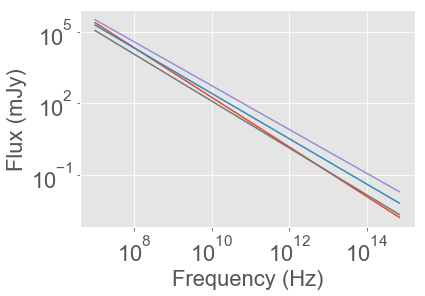

In [47]:
plt.figure()
fig, ax = plt.subplots()

ax.set_yscale("log", nonposy='clip')
ax.set_xscale("log", nonposx='clip')


ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Flux (mJy)')


lowend_freq = 1.0E+07 * u.Hz

extend_radio_fit_x = np.append(lowend_freq.value, nu_optical.to(u.Hz).value)


ax.plot(extend_radio_fit_x, powerlaw(extend_radio_fit_x, amp, index))
ax.plot(extend_radio_fit_x, powerlaw(extend_radio_fit_x, amp_synchrotron, index_synchrotron))

ax.plot(extend_radio_fit_x, powerlaw(extend_radio_fit_x, amp_synchrotron+ampErr_synchrotron, index_synchrotron+indexErr_synchrotron))
ax.plot(extend_radio_fit_x, powerlaw(extend_radio_fit_x, amp_synchrotron-ampErr_synchrotron, index_synchrotron-indexErr_synchrotron))

print(index)

In [48]:
gps_freq = np.arange(0.1*1e1, 100*1e11, 1e9)*u.Hz

def gps_model(nu, a0, a1, a2):
    logS = a0 + np.log10(nu) * (a1 + a2 * np.log10(nu))
    hogan = np.power(10, logS)
    return hogan

In [49]:
hogan = gps_model(gps_freq.value/1e9, 1.92, 0.27, -0.3)

combined_hogan = gps_model(gps_freq.value/1e9, 1.92, 0.27, -0.3) + powerlaw(gps_freq.value, amp, index)


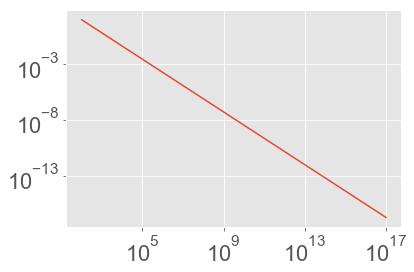

In [50]:
fig, ax = plt.subplots()

ax.set_yscale('log')
ax.set_xscale('log')

ax.plot(full_freq_range,2336*full_freq_range**(-1.18))

### Plotting ###

/Applications/Anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)
/Applications/Anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


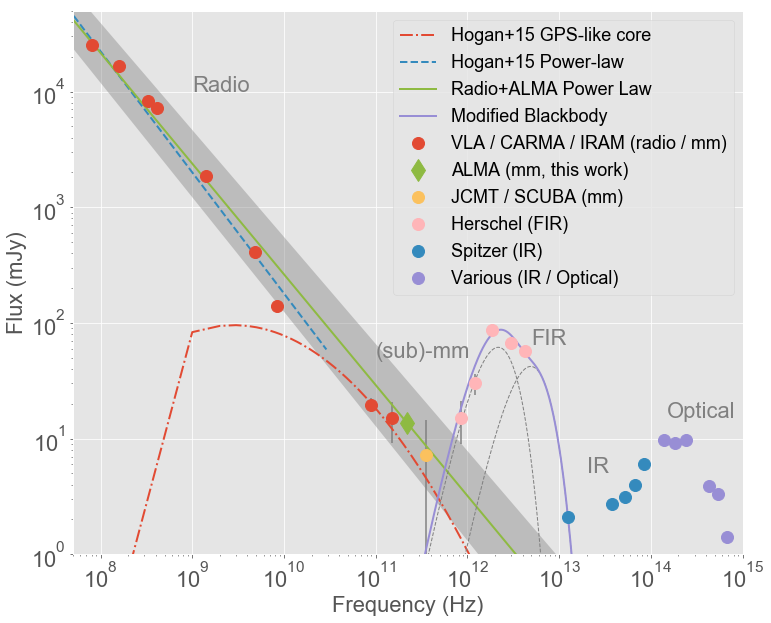

In [51]:

plt.figure()
fig, ax = plt.subplots(figsize=(12,10))


ax.set_yscale("log", nonposy='clip')
ax.set_xscale("log", nonposx='clip')


ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Flux (mJy)')
#ax.set_title('title')

ax.set_xlim(5e7, 1e15)
ax.set_ylim(1,5e4)



ax.errorbar(nu_spitzer.to(u.Hz).value, flux_spitzer.to(u.mJy).value, yerr=flux_err_spitzer.to(u.mJy).value, linestyle='None', color='gray')
ax.errorbar(nu_radio.to(u.Hz).value, flux_radio.to(u.mJy).value, yerr=flux_err_radio.to(u.mJy).value, linestyle='None', color='gray')
ax.errorbar(nu_scuba.to(u.Hz).value, flux_scuba.to(u.mJy).value, yerr=flux_err_scuba.to(u.mJy).value, linestyle='None', color='gray')
ax.errorbar(nu_pacs.to(u.Hz).value, flux_pacs.to(u.mJy).value, yerr=flux_err_pacs.to(u.mJy).value, linestyle='None', color='gray')
ax.errorbar(nu_spire.to(u.Hz).value, flux_spire.to(u.mJy).value, yerr=flux_err_spire.to(u.mJy).value, linestyle='None', color='gray')
ax.errorbar(nu_optical.to(u.Hz).value, flux_optical.to(u.mJy).value, yerr=flux_err_optical.to(u.mJy).value, linestyle='None', color='gray')


markersize_points = 12
almacolor=5



#full_spectrum_fit = graymodel(freq.value,a),'-', linewidth=1.5 + powerlaw(extend_radio_fit_x, amp_synchrotron, index_synchrotron)


lowerbound = powerlaw(extend_radio_fit_x, amp_synchrotron, (index_synchrotron + indexErr_synchrotron))
upperbound = powerlaw(extend_radio_fit_x, amp_synchrotron, (index_synchrotron - indexErr_synchrotron))

ax.fill_between(extend_radio_fit_x, lowerbound, upperbound, facecolor='gray', alpha=0.4)









ax.plot(gps_freq, hogan, '-.', linewidth=2.0,  label="Hogan+15 GPS-like core")
#ax.plot(gps_freq, 2336*gps_freq**(-1.18), '--' , linewidth=2.0, label="Hogan+15 Power-law")

hogan_powerlaw_freq = np.arange(1e7, 3e10, 1e9)

#ax.plot(hogan_powerlaw_freq, powerlaw(hogan_powerlaw_freq, amp, -1.18), '--' , linewidth=2.0, label="Hogan+15 Power-law")
ax.plot(hogan_powerlaw_freq, powerlaw(hogan_powerlaw_freq, amp, index), '--' , linewidth=2.0, label="Hogan+15 Power-law")

# ax.plot(extend_radio_fit_x, powerlaw(extend_radio_fit_x, amp, index), '--' , linewidth=2.0, label="Hogan+15 Power-law")



ax.plot(extend_radio_fit_x, powerlaw(extend_radio_fit_x, amp_synchrotron, index_synchrotron), linewidth=2.0 ,color=plt.rcParams['axes.color_cycle'][almacolor], label="Radio+ALMA Power Law")


ax.plot(freq,graymodel(freq.value,a1),'--', linewidth=1.0, color='gray')
ax.plot(freq,graymodel(freq.value,a2),'--', linewidth=1.0, color='gray')
ax.plot(freq,graymodel(freq.value,a),'-', linewidth=2.0, label='Modified Blackbody')



ax.plot(nu_radio.to(u.Hz).value, flux_radio.to(u.mJy).value, 'o',markersize=markersize_points, label="VLA / CARMA / IRAM (radio / mm)", color=plt.rcParams['axes.color_cycle'][0])
ax.plot(nu_alma.to(u.Hz).value,flux_alma.to(u.mJy).value,'d', markersize=markersize_points+4, label="ALMA (mm, this work)",color=plt.rcParams['axes.color_cycle'][almacolor])
ax.plot(nu_scuba.to(u.Hz).value,flux_scuba.to(u.mJy).value,'o', markersize=markersize_points,label="JCMT / SCUBA (mm)", color=plt.rcParams['axes.color_cycle'][4])
ax.plot(nu_pacs.to(u.Hz).value,flux_pacs.to(u.mJy).value,'o', markersize=markersize_points, color=plt.rcParams['axes.color_cycle'][6])
ax.plot(nu_spire.to(u.Hz).value,flux_spire.to(u.mJy).value,'o',markersize=markersize_points, label="Herschel (FIR)", color=plt.rcParams['axes.color_cycle'][6])
ax.plot(nu_spitzer.to(u.Hz).value,flux_spitzer.to(u.mJy).value,'o',markersize=markersize_points, label="Spitzer (IR)" , color=plt.rcParams['axes.color_cycle'][1])
ax.plot(nu_optical.to(u.Hz),flux_optical.to(u.mJy),'o', markersize=markersize_points, label="Various (IR / Optical)" , color=plt.rcParams['axes.color_cycle'][2])




ax.text(1e9, 1e4, r'Radio', color='gray')
ax.text(1e11, 5e1, r'(sub)-mm', color='gray')
ax.text(5e12, 6.5e1, r'FIR', color='gray')
ax.text(2e13, 5e0, r'IR', color='gray')
ax.text(1.5e14, 1.5e1, r'Optical', color='gray')

##################

ax.legend(loc=0, frameon=True, numpoints=1, prop={'size':18}) 
#ax.legend(loc=0) # let matplotlib decide the optimal location
#ax.legend(loc=1) # upper right corner
#ax.legend(loc=2) # upper left corner
#ax.legend(loc=3) # lower left corner
#ax.legend(loc=4) # lower right corner

fig.savefig("a2597_full_sed_FINAL.pdf", bbox_inches='tight')



From Alastair: 
        1) Figure 3 - You CANNOT simply put a power law through
the <10GHz radio and ALMA continuum points. Mike Hogan has
two additional mm-continuum detections of A2597 in his 2015
paper on high frequency properties of BCGs. 90GHz = 19.7mJy
from CARMA and 150GHz = 15.0mJy from IRAM 30m. These two points
with the ALMA point imply a {much} flatter core than the
"joining the dots" alternative! This is then much more consistent
with the VLBA core fluxes (the star in the attached plot) and hence is
also self-consistent with the detection of CO and HI against
the compact, flatter spectrum core rather than the extended,
steep spectrum lobes that lumping the ALMA flux in with the
spectrum from the lobes implies. (Mike also gives an upper
limit from a more reliable SCUBA-2 observation at 353GHz
that supercedes the old SCUBA one you include in Fig 3.)
